## This will be other measurable aspects of ab40

In [1]:
# 2d_conformational_landscape_map from Shadman, H.

#these packages are needed to run the code 

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
from itertools import chain
from more_itertools import sliced
from matplotlib.ticker import MaxNLocator
import random as rd
import mdtraj as md


In [2]:
# import pdb and trajectories

pdb='/Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40.pdb'
trajectory='/Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40-a99SBdisp-Traj.dcd'
outdir='/Users/NLoui/Desktop/CHEM101.6/FinalProject/outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trajectory:",trajectory)

outdir: /Users/NLoui/Desktop/CHEM101.6/FinalProject/outdir
pdb: /Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40.pdb
trajectory: /Users/NLoui/Desktop/CHEM101.6/FinalProject/data/Ab40-a99SBdisp-Traj.dcd


In [3]:
stride_sel=1
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 598

Number of residues: 40

Number of frames: 29977

Starting frame: 0

Last frame: 29977

sequence:  [ASP1, ALA2, GLU3, PHE4, ARG5, HIS6, ASP7, SER8, GLY9, TYR10, GLU11, VAL12, HIS13, HIS14, GLN15, LYS16, LEU17, VAL18, PHE19, PHE20, ALA21, GLU22, ASP23, VAL24, GLY25, SER26, ASN27, LYS28, GLY29, ALA30, ILE31, ILE32, GLY33, LEU34, MET35, VAL36, GLY37, GLY38, VAL39, VAL40, ASP1, HIS6, HIS13, HIS14]

residue names:  ['ASP', 'ALA', 'GLU', 'PHE', 'ARG', 'HIS', 'ASP', 'SER', 'GLY', 'TYR', 'GLU', 'VAL', 'HIS', 'HIS', 'GLN', 'LYS', 'LEU', 'VAL', 'PHE', 'PHE', 'ALA', 'GLU', 'ASP', 'VAL', 'GLY', 'SER', 'ASN', 'LYS', 'GLY', 'ALA', 'ILE', 'ILE', 'GLY', 'LEU', 'MET', 'VAL', 'GLY', 'GLY', 'VAL', 'VAL', 'ASP', 'HIS', 'HIS', 'HIS']

residue number:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 1, 6, 13, 14]

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

## Determining Secondary Structures of protein

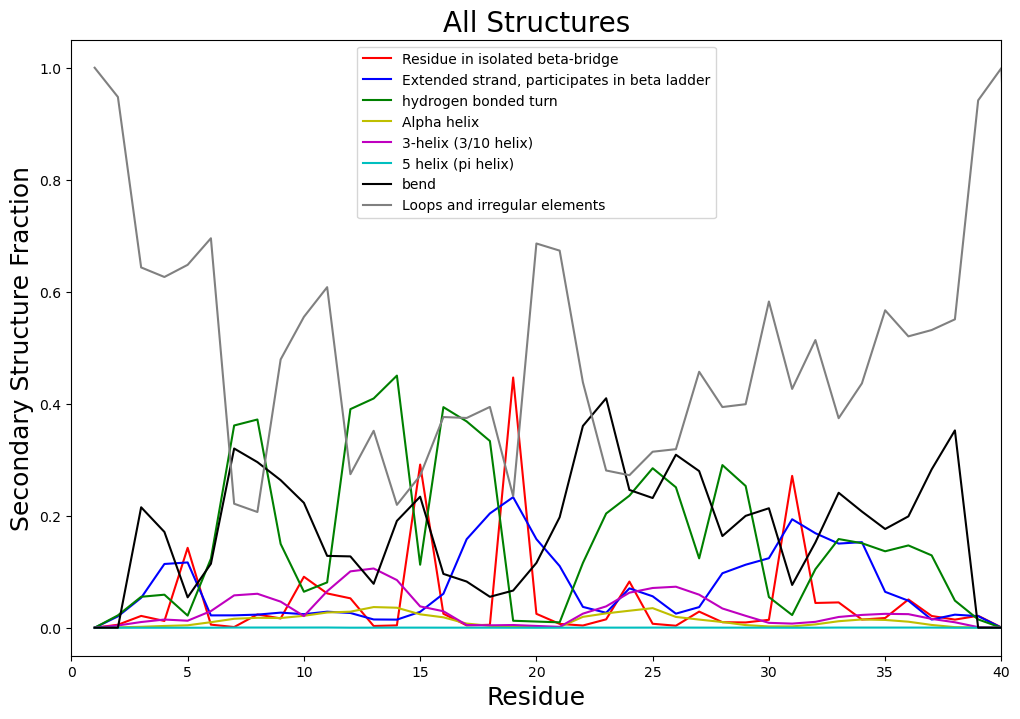

In [5]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert(dssp):
    structures = ['B', 'E', 'T', 'H', 'G', 'I', 'S', ' ']  # Include ' ' (empty string) in the list of structures
    props = {}

    for struct in structures:
        dssp_struct = np.copy(dssp)
        dssp_struct[dssp_struct != struct] = 0
        dssp_struct[dssp_struct == struct] = 1
        dssp_struct = dssp_struct.astype(int)
        
        total_count = np.sum(dssp_struct, axis=1)
        prop = np.sum(dssp_struct, axis=0).astype(float) / len(dssp)
        
        props[struct + 'prop'] = prop
    
    return props

populations = dssp_convert(dssp_full)

# Plot each population
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k', 'gray']
labels = ['B', 'E', 'T', 'H', 'G', 'I', 'S', 'Blank']
title_labels = ['Residue in isolated beta-bridge',
        'Extended strand, participates in beta ladder',
        'hydrogen bonded turn',
        'Alpha helix',
        '3-helix (3/10 helix)',
        '5 helix (pi helix)','bend',
        'Loops and irregular elements']

res_num = list(range(1, 45))  # Ensure res_num has the correct length

plt.figure(figsize=(12, 8))  # Create a single figure

for struct, pop, color, label, title_label in zip(populations.keys(), populations.values(), colors, labels, title_labels):
    #print(f"Length of res_num: {len(res_num)}")
    #print(f"Length of pop for {struct}: {len(pop)}")
    if len(res_num) != len(pop):
        print(f"Error: res_num and pop for {struct} do not match in length.")
    else:
        plt.plot(res_num, pop, c=color, label=title_label)  # Plot each curve

# Set labels and title outside the loop
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.title('All Structures', size=20)
plt.legend()  # Create a legend with all labels
plt.xlim(0,40)
plt.savefig('secondary structure',dpi=1200)
plt.show()  # Show the plot once after the loop

        

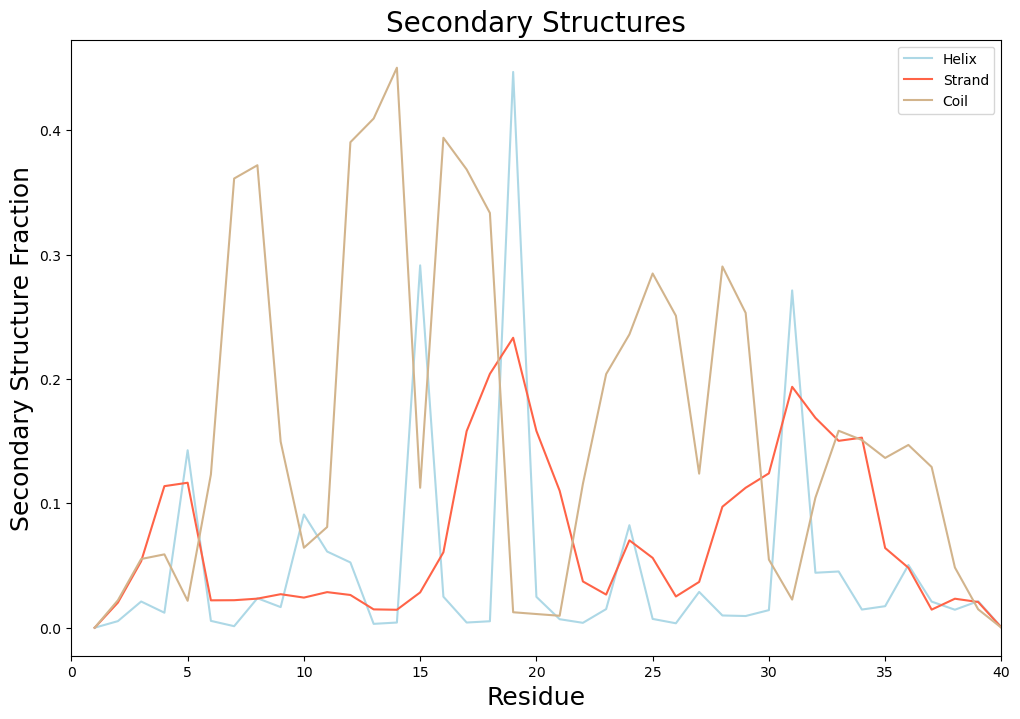

In [6]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_sel_prop(dssp):
    structures = ['H','E','C']
    # Dictionary to store residue numbers for each structure type
    props={}


    for struct, prop_value in proportions.items():
        dssp_struct = np.copy(dssp)
        dssp_struct[dssp_struct != struct] = 0
        dssp_struct[dssp_struct == struct] = 1
        dssp_struct = dssp_struct.astype(int)
        
        total_count = np.sum(dssp_struct, axis=1)
        prop = np.sum(dssp_struct, axis=0).astype(float) / len(dssp_struct)
        
        props[struct + 'prop'] = prop
        
    return props

colors = ['lightblue', 'tomato', 'tan']
labels = ['H', 'E', 'C']
title_labels = ['Helix',
        'Strand',
        'Coil']

res_num = list(range(1, 45))  # Ensure res_num has the correct length

plt.figure(figsize=(12, 8))  # Create a single figure

for struct, pop, color, label, title_label in zip(populations.keys(), populations.values(), colors, labels, title_labels):
    #print(f"Length of res_num: {len(res_num)}")
    #print(f"Length of pop for {struct}: {len(pop)}")
    if len(res_num) != len(pop):
        print(f"Error: res_num and pop for {struct} do not match in length.")
    else:
        plt.plot(res_num, pop, c=color, label=title_label)  # Plot each curve

# Set labels and title outside the loop
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.title('Secondary Structures', size=20)
plt.legend()  # Create a legend with all labels
plt.xlim(0,40)
plt.savefig('secondary structure simple',dpi=1200)
plt.show()  # Show the plot once after the loop

## Determining Walks of Protein Backbone, in 3D

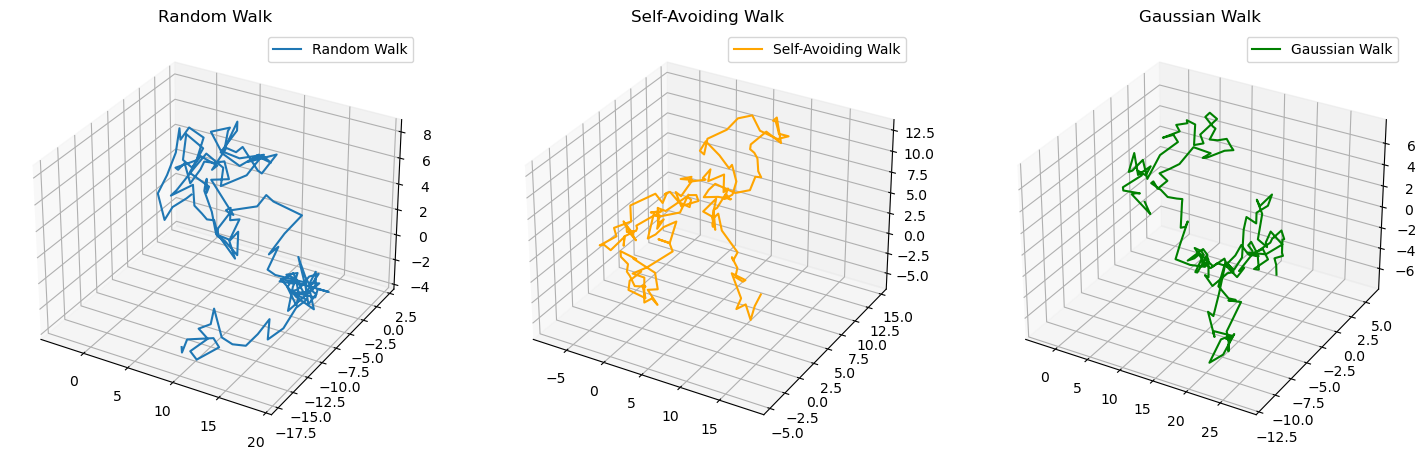

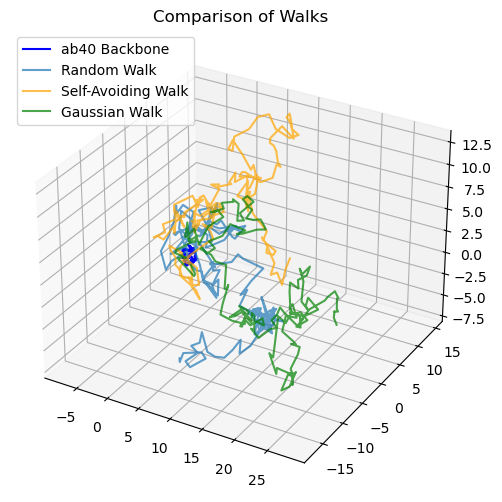

In [7]:
# Extract backbone atom indices (N, CA, C atoms)
backbone_atoms = trj.topology.select('backbone')

# Calculate the backbone atom coordinates
backbone_coords = trj.atom_slice(backbone_atoms).xyz

# Define the length of the walk
N = backbone_coords.shape[1]

# Simulate Random Walk (RW)
def random_walk(N):
    steps = np.random.randn(N, 3)
    rw = np.cumsum(steps, axis=0)
    return rw

# Simulate Self-Avoiding Walk (SAW)
def self_avoiding_walk(N):
    saw = np.zeros((N, 3))
    visited = set()
    visited.add(tuple(saw[0]))

    for i in range(1, N):
        while True:
            step = np.random.randn(3)
            next_pos = saw[i-1] + step
            next_pos_tuple = tuple(next_pos)
            if next_pos_tuple not in visited:
                saw[i] = next_pos
                visited.add(next_pos_tuple)
                break
    return saw

# Simulate Gaussian Walk (GW)
def gaussian_walk(N):
    gw = np.cumsum(np.random.normal(size=(N, 3)), axis=0)
    return gw

# Generate walks
rw_path = random_walk(N)
saw_path = self_avoiding_walk(N)
gw_path = gaussian_walk(N)

# Plot the walks
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(rw_path[:, 0], rw_path[:, 1], rw_path[:, 2], label='Random Walk')
ax1.set_title('Random Walk')
ax1.legend()

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(saw_path[:, 0], saw_path[:, 1], saw_path[:, 2], label='Self-Avoiding Walk', color='orange')
ax2.set_title('Self-Avoiding Walk')
ax2.legend()

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(gw_path[:, 0], gw_path[:, 1], gw_path[:, 2], label='Gaussian Walk', color='green')
ax3.set_title('Gaussian Walk')
ax3.legend()

plt.show()
fig.savefig('walks',dpi=1200)

# Compare the real protein's backbone with the walks
real_backbone = backbone_coords[0]

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(111, projection='3d')
ax.plot(real_backbone[:, 0], real_backbone[:, 1], real_backbone[:, 2], label='ab40 Backbone', color='blue')
ax.plot(rw_path[:, 0], rw_path[:, 1], rw_path[:, 2], label='Random Walk', alpha=0.7)
ax.plot(saw_path[:, 0], saw_path[:, 1], saw_path[:, 2], label='Self-Avoiding Walk', alpha=0.7, color='orange')
ax.plot(gw_path[:, 0], gw_path[:, 1], gw_path[:, 2], label='Gaussian Walk', alpha=0.7, color='green')
ax.set_title('Comparison of Walks')
ax.legend()

plt.show()

fig.savefig('comparison of walks',dpi=1200)

## Determining Phi/Psi/Chi1/Chi2 of ab40

In [8]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [9]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return


### Lets Calculate the RMSD and make a histogram from the starting structure 

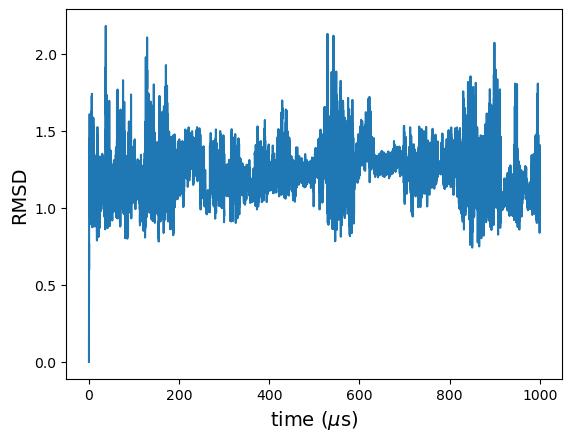

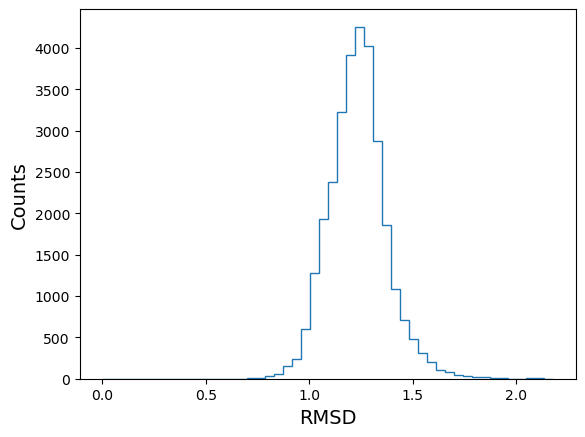

In [10]:
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.savefig('ab40 RMSD',dpi=1200)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.savefig('ab40 rmsd counts and his',dpi=1200)
plt.show()

### Lets calculate the radius of gyration and make a histogram

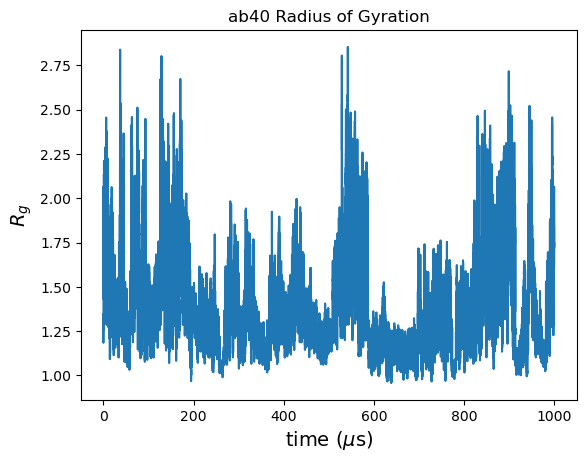

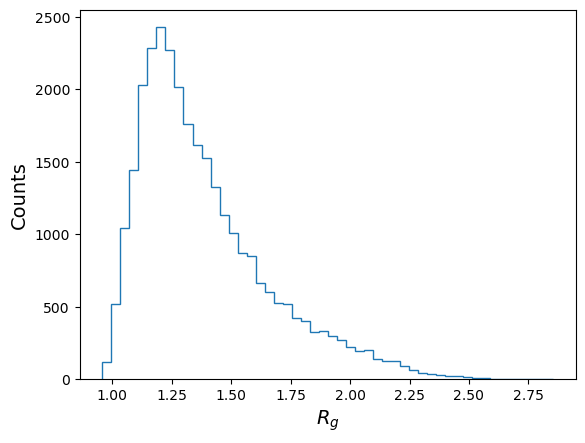

In [11]:
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('$R_g$',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.title('ab40 Radius of Gyration')
plt.savefig('ab40 Rg 2',dpi=1200)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('$R_g$',size=14)
plt.savefig('ab40 counts and his',dpi=1200)
plt.show()

## Determining Principal component analyses of trajectory

In [12]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(29977, 2)


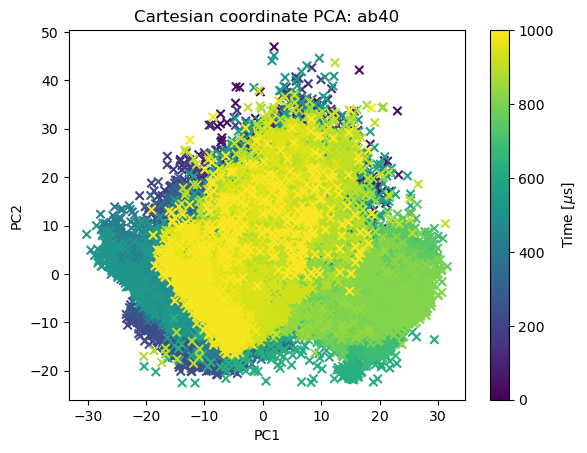

In [13]:
#We Can plot each frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: ab40')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

plt.savefig('ab40 cart pca 2',dpi=1200)

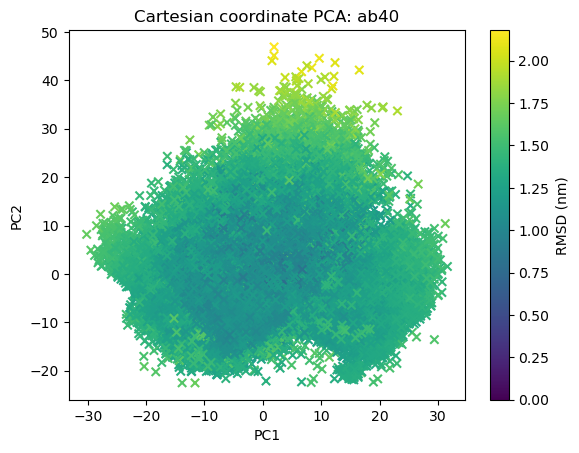

In [14]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: ab40')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

plt.savefig('ab40 cart pca',dpi=1200)

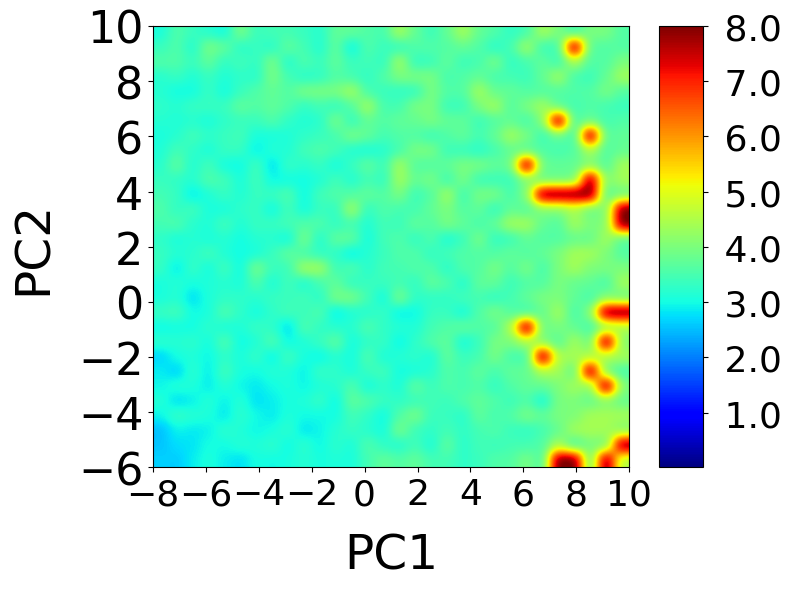

In [15]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.savefig('ab40 pc',dpi=1200)
plt.tight_layout()

### Determining overall structure of protein

In [16]:
residue_number=40
array_index=residue_number-0

dssp=md.compute_dssp(trj,simplified=True)
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)

# Extract secondary structure information for the whole tr
timeframe_indices = range(0,1000) 
timeframe_dssp = dssp[timeframe_indices, array_index]

# Count the occurrences of each secondary structure element
helix_count = np.sum(timeframe_dssp == 'H')
beta_count = np.sum(timeframe_dssp == 'E')
coil_count = np.sum(timeframe_dssp == 'C')

# Determine the dominant secondary structure element
dominant_structure = None
if helix_count > beta_count and helix_count > coil_count:
    dominant_structure = 'H'
elif beta_count > helix_count and beta_count > coil_count:
    dominant_structure = 'E'
else:
    dominant_structure = 'C'
    
#
def dssp_convert(dssp):
    structures = ['H','E','C','NA'] 
    props = {}

    for struct in structures:
        dssp_struct = np.copy(dssp)
        dssp_struct[dssp_struct != struct] = 0
        dssp_struct[dssp_struct == struct] = 1
        dssp_struct = dssp_struct.astype(int)
        
        total_count = np.sum(dssp_struct, axis=1)
        prop = np.sum(dssp_struct, axis=0).astype(float) / len(dssp)
        
        props[struct + 'prop'] = prop
    
    return props

populations = dssp_convert(dssp)

# Print the results
print("Dominant secondary structure in the timeframe:")
print("Helix (H) count:", helix_count)
print("Beta-sheet (E) count:", beta_count)
print("Coil (C) count:", coil_count)
print("Dominant structure:", dominant_structure)

Dominant secondary structure in the timeframe:
Helix (H) count: 0
Beta-sheet (E) count: 0
Coil (C) count: 0
Dominant structure: C


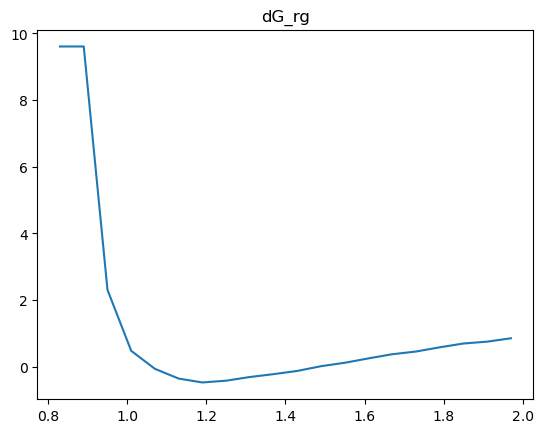

In [17]:
def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)
plt.title('dG_rg')
plt.plot(xedges,dG_rg)

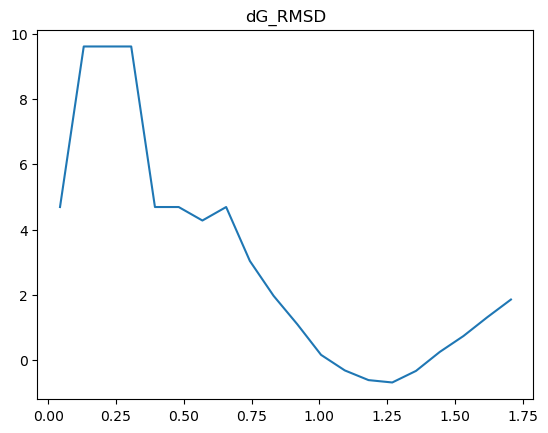

In [18]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.title('dG_RMSD')
plt.plot(xedges,dG_RMSD)

ꜛꜛ
Free Energy Landscape
a free energy landscape represents the energy landscape of a system as a function of one or more collective variables. It provides valuable insight into the stability and dynamics of the system by revealing the thermodynamically favorable states and barriers between them.

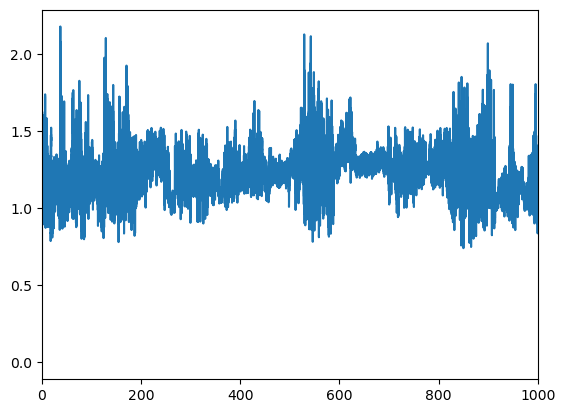

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.300e+01,
        2.800e+01, 6.300e+01, 1.500e+02, 2.340e+02, 6.000e+02, 1.281e+03,
        1.937e+03, 2.385e+03, 3.225e+03, 3.920e+03, 4.258e+03, 4.020e+03,
        2.880e+03, 1.854e+03, 1.091e+03, 7.140e+02, 4.760e+02, 3.110e+02,
        2.010e+02, 1.050e+02, 8.100e+01, 4.500e+01, 3.200e+01, 2.000e+01,
        1.600e+01, 1.000e+01, 6.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        4.000e+00, 1.000e+00]),
 array([0.        , 0.04360421, 0.08720842, 0.13081263, 0.17441684,
        0.21802106, 0.26162526, 0.30522949, 0.34883368, 0.39243791,
        0.43604213, 0.47964633, 0.52325052, 0.56685477, 0.61045897,
        0.65406317, 0.69766736, 0.74127162, 0.78487581, 0.82848001,
        0.87208426, 0.91568846, 0.95929265, 1.0028969 , 1.04650104,
        1.0901053 , 1.13370955, 1.17

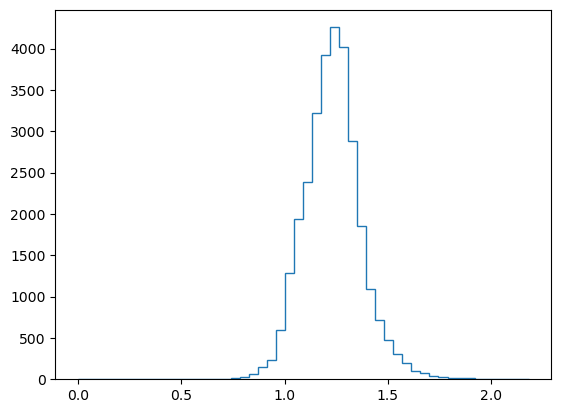

In [19]:
plt.plot(time,rmsd)
plt.xlim(0,1000)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)

## Compare RMSD vs Rg

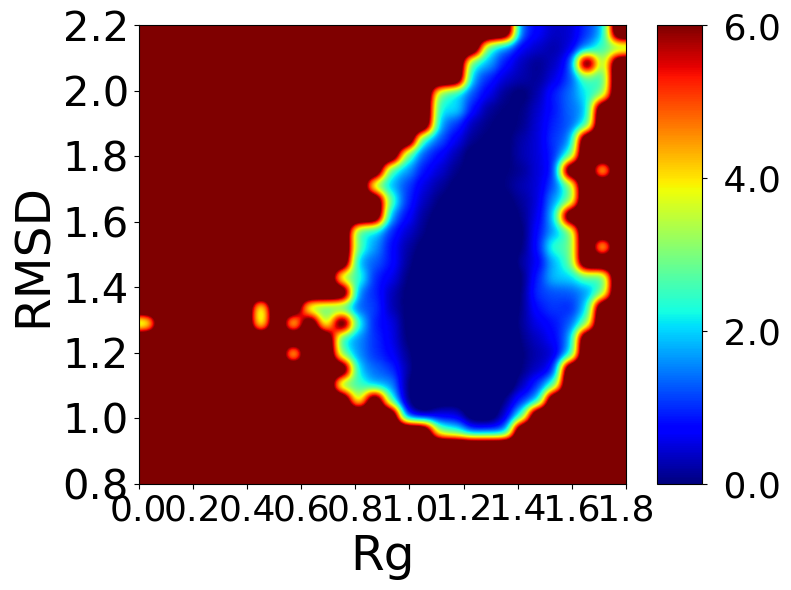

In [20]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35)
plt.xlabel("Rg", size=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.savefig('ab40 rmsd vs rg',dpi=1200)
plt.tight_layout()

## Lets Make a Contact Map

In [21]:
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
    if (i % n !=0):
        sequence[i]=''

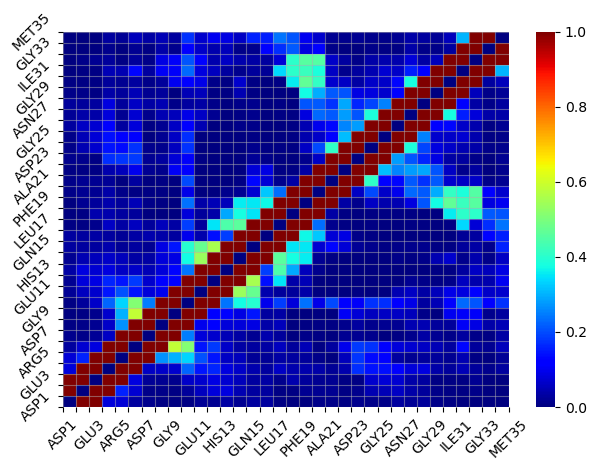

In [22]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.tight_layout()
plt.savefig('ab40_contactmap',dpi=1200)
plt.show()

In [23]:
rg=md.compute_rg(trj, masses=None)

rg_mean = np.mean(rg)

rg_x=rg / rg_mean
rg_x

array([0.91320841, 0.94681116, 0.91519778, ..., 1.44695685, 1.39739346,
       1.2574765 ])

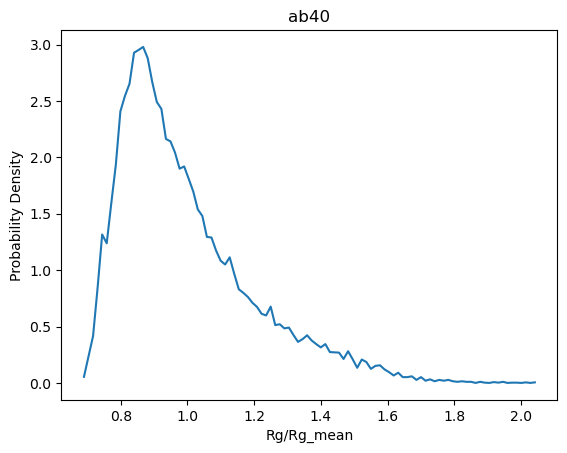

In [24]:
probability_density, bins = np.histogram(rg_x, bins=100, density=True)

# Plot
plt.plot(bins[:-1], probability_density)
plt.xlabel('Rg/Rg_mean')
plt.ylabel('Probability Density')
plt.title('ab40')
plt.savefig('ab40_probability',dpi=1200)
plt.show()

In [26]:
ree_squared = pd.read_csv("ree_squared.csv")
rg_squared = pd.read_csv("rg_squared.csv")

print(ree_squared)
print(rg_squared)


       Ree_squared
0         6.709018
1         4.863108
2         5.104583
3         4.286687
4         5.671422
...            ...
29972     9.452365
29973    14.539665
29974    10.773950
29975     3.801325
29976     8.065620

[29977 rows x 1 columns]
       Rg_squared
0        1.608304
1        1.728841
2        1.615318
3        1.402557
4        1.612576
...           ...
29972    3.608211
29973    3.600546
29974    4.037749
29975    3.765873
29976    3.049495

[29977 rows x 1 columns]


In [27]:
Rs = []

# Iterate over the columns of ree_squared and rg_squared
for col1, col2 in zip(ree_squared, rg_squared):
    # Perform element-wise division between corresponding columns
    Rs.append(ree_squared[col1] / rg_squared[col2])

# Concatenate the resulting Series into a DataFrame
Rs = pd.concat(Rs, axis=1)

print(Rs)

              0
0      4.171487
1      2.812929
2      3.160109
3      3.056337
4      3.516996
...         ...
29972  2.619682
29973  4.038183
29974  2.668306
29975  1.009414
29976  2.644903

[29977 rows x 1 columns]


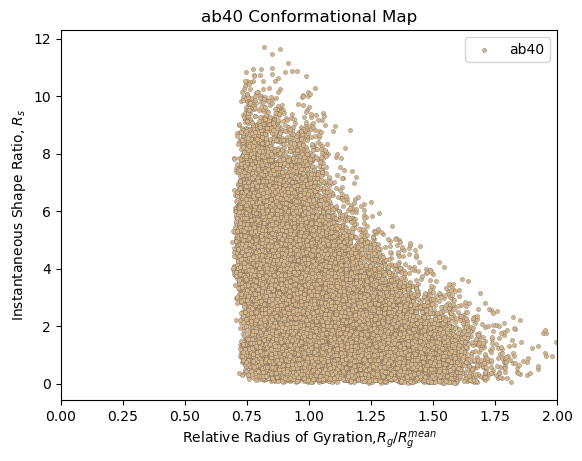

In [28]:
plt.scatter(rg_x, Rs,s=10,c='tan',edgecolors='k',linewidths=0.1)
#plt.xlabel('Relative Radius of Gyration, Rg/Rg_mean')
plt.xlabel('Relative Radius of Gyration,$R_g / R_{g}^{mean}$')
plt.ylabel('Instantaneous Shape Ratio, $R_{s}$')
plt.xlim((0,2))
plt.title('ab40 Conformational Map')
plt.legend(["ab40"])
plt.savefig('ab40_conform_map',dpi=1200)
plt.show()

## Finding Frames in Visual Simulation based on conformational map


In [46]:
## Finding max and min of Rs values, and associated frames
Rs_np = Rs.to_numpy()

# Get the index of the max and min values
rs_max_index = np.argmax(Rs_np)
rs_min_index = np.argmin(Rs_np)

# Print the indices and the max and min values
print(f"Index of max value: {rs_max_index}")
print(f"Max value: {Rs_np[rs_max_index]}")

print(f"Index of min value: {rs_min_index}")
print(f"Min value: {Rs_np[rs_min_index]}")

Index of max value: 7329
Max value: [11.7075886]
Index of min value: 28366
Min value: [0.02464917]


In [30]:
## Finding max and min of $R_g / R_{g}^{mean}$ (Rg_x) values, and associated frames

# Get the index of the max and min values
max_index = np.argmax(rg_x)
min_index = np.argmin(rg_x)

# Print the indices
print(f"Index of max value: {max_index}")
print(f"Index of min value: {min_index}")

# Print the max and min values
print(f"Max value: {rg_x[max_index]}")
print(f"Min value: {rg_x[min_index]}")

Index of max value: 16255
Index of min value: 19134
Max value: 2.0554714042871063
Min value: 0.6895161492563431


In [32]:
# Find the median of 
rg_x_median = np.median(rg_x)

print("Median:", rg_x_median)

Rs_median = np.median(Rs_np)

print("Median:", Rs_median)

Median: 0.9483792508547245
Median: 2.7372398499424797


In [33]:
# reform data array
# Reshape rg_x to have the same number of rows as Rs_np and one column
rg_x_reshaped = rg_x.reshape(-1, 1)

# Combine the two arrays along the columns axis (axis=1)
Rs_rgx = np.concatenate((Rs_np, rg_x_reshaped), axis=1)

print("Combined NumPy Array:")
print(Rs_rgx)

Combined NumPy Array:
[[4.17148733 0.91320841]
 [2.81292911 0.94681116]
 [3.16010928 0.91519778]
 ...
 [2.66830614 1.44695685]
 [1.00941381 1.39739346]
 [2.64490319 1.2574765 ]]


In [47]:
##Find the min Rs frame near the median of Rg/Rg_mean

# Values to match
Rs_val = Rs_np[rs_min_index]
print(Rs_val)
rg_x_val = np.median(rg_x)

# Tolerance level
tolerance = 0.05

# Find rows where column 1 is close to Rs_val and column 2 is close to rg_x_val
matching_rows = []
for i, row in enumerate(Rs_rgx):
    if abs(row[0] - Rs_val) < tolerance and abs(row[1] - rg_x_val) < tolerance:
        matching_rows.append(i)

if len(matching_rows) > 0:
    print(f"Row number(s) where column 1 is close to {Rs_val} and column 2 is close to {rg_x_val}: {matching_rows}")
else:
    print("No matching rows found.")

[0.02464917]
Row number(s) where column 1 is close to [0.02464917] and column 2 is close to 0.9483792508547245: [12986]
